# Pre-trained DoomBasic agent demo

* see the other notebook for how it was trained

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="device=cpu"
env: OPENMP_NUM_THREADS=6


In [2]:
from scipy.misc import imresize
#game image will be resized from(96,128) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN

IMAGE_W,IMAGE_H = IMAGE_SIZE =(60,80)#(96,128)
def preprocess(obs):
    return (imresize(obs,IMAGE_SIZE).mean(-1)/255.)

class Frameskipper:
    def __init__(self,env,frameskip=4):
        self.env=env
        self.frameskip=frameskip
    def step(self,action):
        
        total_reward = 0.
        for i in range(self.frameskip):
            obs,r,done,info = self.env.step(action)
            total_reward += r
            if done: break
        
        return obs,total_reward,done,info
    def __getattr__(self,attr):
        if attr == 'step':
            return self.step
        else:
            return getattr(self.env,attr)

In [3]:
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
GAME_NAME = 'ppaquette/DoomBasic-v0'
env = Frameskipper(ToDiscrete("minimal")(gym.make(GAME_NAME)))

[2016-11-28 03:26:10,011] Making new env: ppaquette/DoomBasic-v0


-4.0 False


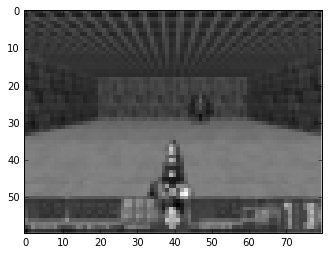

In [5]:
env.reset()
obs,r,done,_=env.step(1)
print r, done
plt.imshow(preprocess(obs),cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

In [10]:
import lasagne
from lasagne.layers import *
from agentnet.memory import WindowAugmentation

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))


#store 4-tick window in order to perceive motion of objects
prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))
current_window = WindowAugmentation(observation_layer,prev_window)


#main neural network body
conv0 = Conv2DLayer(current_window,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense0 = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [11]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [12]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              agent_states={current_window:prev_window},
              action_layers=action_layer)


In [16]:
from agentnet.utils.persistence import load
load(action_layer,"./doombasic_dqn_2500.pcl")

In [17]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,lambda:Frameskipper(ToDiscrete("minimal")(gym.make(GAME_NAME))), 
               preprocess_observation=preprocess,
               n_games=1)


[2016-11-28 03:28:41,812] Making new env: ppaquette/DoomBasic-v0


# Demo run

In [18]:
action_layer.epsilon.set_value(0)

In [20]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True,n_games=10)

[2016-11-28 03:29:13,366] Making new env: ppaquette/DoomBasic-v0
[2016-11-28 03:29:13,375] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 88 timesteps with reward=-455.0
Episode finished after 8 timesteps with reward=72.0
Episode finished after 8 timesteps with reward=72.0
Episode finished after 5 timesteps with reward=84.0
Episode finished after 4 timesteps with reward=88.0
Episode finished after 10 timesteps with reward=59.0
Episode finished after 4 timesteps with reward=88.0
Episode finished after 5 timesteps with reward=84.0


[2016-11-28 03:29:16,818] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 5 timesteps with reward=84.0
Episode finished after 4 timesteps with reward=88.0


# show random game
* re-run tab to get a different game (chosen randomly)
* if your browser does not support this, just go to records in jupyter file manager and download the videos

In [24]:
from IPython.display import HTML
import os
from random import choice

video_fnames = [os.path.join("records",fname) 
                for fname in os.listdir("./records/") if fname.endswith("mp4")]

assert len(video_fnames) >0 #please record some sessions above

video_path=choice(video_fnames)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))